# Final Project
## ITU Machine Learning Fall 2021
### Decision Tree

#### This notebook contains the code for the Decision Tree part of our final project.

#### Group AC
Chrisanna Cornish <ccor@itu.dk> <br>
Carl August Wismer <cwis@itu.dk><br>
Danielle Marie Dequin <ddeq@itu.dk>

Last Edited: 01/01/2021

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
# code from exercise 5 to calculate the z-score
z_score = lambda x : (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def conf_mat(y_hat, y_true):
    '''Returns a confusion matrix'''
    n = max(y_hat)+1
    bingo = np.zeros([n,n])
    for i in range(len(y_hat)):
        bingo[y_true[i]][y_hat[i]] +=1
    
    return(bingo)

def scores(y_hat, y_true, average = False):
    '''For each class, returns recall, precision and f1'''
    classes = list(np.unique(y_true))
    conf = conf_mat(y_hat, y_true)
    r = []
    p = []
    f = []
    for c in classes:
        recall = conf[c][c] / sum(conf[c])
        precision = conf[c][c] / sum(conf[:, c])
        f1 = 2*(precision*recall)/(precision + recall)
        r.append(recall)
        p.append(precision)
        f.append(f1)
    if average:
        return sum(r)/len(r), sum(p)/len(p), sum(f)/len(f)
    else:
        return (r, p, f)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    Function copied from exercise 7.
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Variables and df loading

In [4]:
col = 'rainbow' # Colour theme

df = pd.read_csv(TRAIN) # Training dataframe
print(len(df))

# ensures data is without order, random state fixed for reproducability, frac=1 gives the whole df back but shuffled
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(len(df)) # confirm still have the whole df

attributes = list(df.columns)[:-1] # Creates list of column names for the dataframe without the class

X = df[attributes].copy() # Attributes
y = df['type'].copy() # True values

y_list = y.unique() # 'y' values

for i in range(len(y)):
    if y[i] > 4:
        y[i] = y[i] - 2
    else:
        y[i] = y[i] - 1

    
df.head(3) # decision trees are not affected by scale so don't need to standardise the data

149
149


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.0,0.00,2
1,1.51627,13.00,3.58,1.54,72.83,0.61,8.04,0.0,0.00,2
2,1.51796,13.50,3.36,1.63,71.94,0.57,8.81,0.0,0.09,3


# Decision Tree Functions and Class
This is the code for implementing a Decision Tree from Scratch

## Gini Impurity Function

In [5]:
def Gini(g_df, y,threshold):
    '''Function to calculate the Gini Impurity at the given split in the data
    for use in a Decision Tree Classifier.
    
    Input Parameters
    ----------
    
    g_df: A pandas dataframe with all rows of the data, in one specific column (attribute) only. 
    Does not include the class label.
    
    y: A pandas dataframe of all the class labels for each row.
    
    threshold: The given threshold to divide the data for use in calculating the impurity.
    
    Returns
    ----------
    gini: The Gini Impurity value used to decide if the given split is the optimal. 
    Calculation is a linear combination of the weighted gini of the left node plus 
    the weighted gini of the right node.
    
    node_gini: The impurity of the whole input data.
    
    class_count: a list of the number assigned to each class, 
    used to calc impurity and later for classification.
    
    '''
    
    g_df = pd.concat([g_df,y], axis=1,)
    g_df.columns=['Att', 'class']
    
    # Initialize an array of zeros to count number of each class in the whole node
    class_count = np.zeros((8), dtype=int)
    for i in range(len(g_df)):
        class_count[g_df['class'].iloc[i]]+=1

    
    # Proportion of each class present out of the total count
    proportion = [class_count[i]/np.sum(class_count) for i in range(len(class_count))]
    
    # Calculate the gini impurity for the entire node (is not used to calculate if the split is optimal)
    node_gini = 0
    for i in range(len(proportion)):
        node_gini += proportion[i]*(1-proportion[i])  
    
    # Split the data using the given attribute and threshold
    df_a = g_df[g_df['Att'] <= threshold]
    df_b = g_df[g_df['Att'] > threshold]
    
    n = g_df.shape[0] # Length of the whole node
    n_a = df_a.shape[0] # Length of side a
    n_b = df_b.shape[0] # Length of side b
    
    # Calculate and return gini impurity for each side
    gini_a = 0
    gini_b = 0
    for k in y_list: # loop through all classes
        
        k_a = df_a[df_a['class'] == k] 
        p_ka = len(k_a)/len(df_a) # Count of class k in split a, divided by total in that side.
        
        k_b = df_b[df_b['class'] == k]
        p_kb = len(k_b)/len(df_b) # Count of class k in split b, divided by total in that side.
                
        gini_a += (p_ka* (1-p_ka)) # Add p(1-p) of side a to the gini of side a
        gini_b += (p_kb* (1-p_kb)) # Add p(1-p) of side b to the gini of side b
        
    # Weighted gini impurity score that decides if the split is optimal    
    gini = (n_a/n)*gini_a + (n_b/n)*gini_b
    
    #print(round(gini_a, 3), round(gini_b, 3)) #The gini scores of each leaf
    
    return gini, node_gini, class_count # weighted gini from leaves != overall node gini


### Testing Gini Functionality

In [6]:
Gini(df['Ba'],y, 0.4) # Should be 0.736, accoding to SKlearn Reference

(0.3737915468200703,
 0.7355524525922255,
 array([49, 53, 12,  9,  6, 20,  0,  0]))

## Function to find the best split

In [7]:
def leaf_hunter(df, class_name = 'type'):
    '''Greedy function that calculates the optimal split in data at a node for a Decision Tree Classifier.
    
    Inputs
    ---------
        df : a dataframe with all attributes and rows, including class labels.
    
    Returns a dictionary with the following values:
    ---------
        best_gini : best weighted leaf gini scores (used to decide the optimal split)
        best_threshold : best threshold to split the data
        best_att : best attribute (used to decide how to split the data)
        node_gini : node gini score
        class_count : class counts for the imput node that is being split
    '''
    attributes = list(df.columns)[:-1]
    
    # Initialize variables
    best_gini = 1
    best_class = ''
    best_threshold = 0
    best_att = 0
    class_cnt = 0
    node_gini = 0
    
    # If there is only 1 row in the data, the node cannot be split
    if df.shape[0] == 1:
        class_count = np.zeros((8), dtype=int)
        for i in df[class_name]:
            class_count[i] += 1
        return {'best_gini': 0, 
                'best_threshold': 0, 
                'best_att': 0, 
                'node_gini': 0,
                'class_count': class_count}
    
    for a in attributes: # Loop through attribute
        # Sort the data frame of the present attribute
        tmp = df.sort_values(by=a, axis=0).copy()
        
        for threshold in range(len(df)-1): # Loop through potential thresholds, which are points halfway between each data point
            
            if tmp[a].iloc[threshold] != tmp[a].iloc[threshold+1]: # Skip if the two points are the same value
                thresh = (tmp[a].iloc[threshold] + tmp[a].iloc[threshold+1])/2
                
                # Calculate the gini impurity at that split
                gini, node_gini, class_count = Gini(df[a], df[class_name], thresh)
                
                # If the gini impurity is lower, overwrite the variables to the current settings
                if gini < best_gini:
                    best_gini = gini
                    best_threshold = thresh
                    best_att = a
                    class_cnt = class_count
                
    return {'best_gini': best_gini, 
            'best_threshold': best_threshold, 
            'best_att': best_att, 
            'node_gini': node_gini,
            'class_count': class_count}


## Testing the leaf_hunter functionality

In [8]:
leaf = leaf_hunter(df)

print(leaf)

{'best_gini': 0.6199065196548418, 'best_threshold': 0.4, 'best_att': 'Ba', 'node_gini': 0.7355524525922255, 'class_count': array([ 0, 49, 53, 12,  0,  9,  6, 20])}


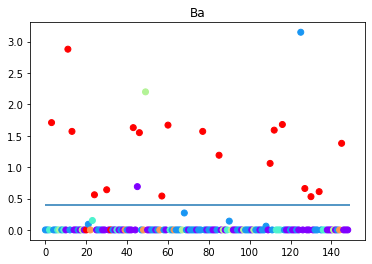

In [9]:
# Visualize the first split in the data
plt.scatter([i for i in range(len(df))], df[leaf["best_att"]], c=y, cmap=col)
plt.hlines(leaf["best_threshold"], 0, 149)
plt.title(f"{leaf['best_att']}");
#plt.savefig('../Vis/split 1');

## Decision Tree Class

In [10]:
class DecisionTree:
    '''A Decision Tree Classifier. Initializes a node based on the input dataframe. Then splits the node using
    the leaf_hunter function. Each split is initialized as a new node, which is recursively split until there is 
    only 1 class left in the node, or the intitialized max depth is reached.
    '''
    
    def __init__(self, df, class_name_ = 'type', max_depth=20, print_nodes=False, depth=0, tree_text = False):     
        ''' 
        Parameters:
        -----------
        df : Complete dataframe, including class labels
        max_depth : Depth of the tree, Default=20
        print_nodes : Bool that triggers whether or not to print the nodes of the tree, default=False
        depth : Initial depth of the tree, default=0
        tree_text : Bool that triggers whether the tree should be output to a text file. Default=False
        '''
        
        # Use leaf_hunter function to find the optimal split in the data, and set the variables accordingly
        tmp = leaf_hunter(df, class_name_)
        self.depth = depth
        self.node_gini = tmp['node_gini']
        self.best_gini = tmp['best_gini']
        self.best_att = tmp['best_att']
        self.best_threshold = tmp['best_threshold']
        self.class_count = tmp['class_count']
        self.no_classes = len(np.nonzero(self.class_count)[0])
        self.max_depth = max_depth
        self.classification = int(np.where(self.class_count == np.amax(self.class_count))[0][0]) 
        self.df = df
        
        # If there is only 1 class present in the node, it cannot be further split
        if self.no_classes == 1 or self.max_depth < 1:
            self.has_children = False
        else:
            self.has_children = True
        
        # If parameter print_nodes=True, print the node
        if print_nodes:
            print(self)
        
        if tree_text:
            # If node depth==0, start a new document and write node to it
            if self.depth==0:
                with open('../Report/tree.txt', 'w') as f:
                    f.write(f'{str(self)}')
            # Else, append new node to the document
            else:
                with open('../Report/tree.txt', 'a') as f:
                    f.write(f'{str(self)}')
                
        if self.has_children:
            a = df[df[self.best_att] <= self.best_threshold]
            b = df[df[self.best_att] > self.best_threshold]
            self.child_a = DecisionTree(a, class_name_, self.max_depth-1, print_nodes, self.depth+1, tree_text)
            self.child_b = DecisionTree(b, class_name_, self.max_depth-1, print_nodes, self.depth+1, tree_text)
            
    def __str__ (self):
        '''__str__ method for the class, used for printing the node attributes.
        '''
        attributes = list(self.df.columns)[:-1]
        peanut = {attributes[i]: i for i in range(len(attributes))}
        peanut[0] = ''
        
        return(f'Depth: {self.depth}'
              + f'\n{"  "*self.depth}Node Gini: {self.node_gini}'
              + f'\n{"  "*self.depth}Attribute: {self.best_att} ({peanut[self.best_att]})'
              + f'\n{"  "*self.depth}Threshold: {self.best_threshold}'
              + f'\n{"  "*self.depth}Classes: {self.class_count}'
              + f'\n{"  "*self.depth}No classes: {self.no_classes}'
              + f'\n{"  "*self.depth}Node classification: {self.classification}'
              + f'\n{"  "*self.depth}Has children: {self.has_children}'
              + f'\n{"  "*self.depth}-----------------------\n')
        
    def predict(self, test, force_depth=100):
        '''Predict method.
        Parameters
        ----------
            test : test data frame to have classes predicted based on the trained decision tree
            force_depth : forces the classifier to stop at the given depth, even if further
                          child nodes are present. This is used when the optimum depth is being
                          discovered during hyperparameter tuning
                          
                          
                          
        Returns
        ----------
            classes: The predicted classes for each row in the test data frame. 
        '''
        # Initialize an empty list to contain all of the class predictions
        classes = []
        # Loop through each row in the test data
        for i in range(len(test)):
            t = test.iloc[i]
            searching = True
            sam = self # Makes sam a copy of the decision tree
            
            '''For each datapoint in the test list, follow the tree down until in ends in a leaf node,
            or reaches a set depth and then takes its classification from the node it ends in.
            This means we don't have to re-train the model when looking for the optimum depth.
            '''
            while searching:
                # If not at a leaf node or max depth
                if sam.has_children and sam.depth < force_depth:  
                    # If attribute goes to the left in the decision node
                    if t[sam.best_att] <= sam.best_threshold:
                        # Go to the left node
                        sam = sam.child_a
                    # Else go to the right node
                    else:
                        sam = sam.child_b
                else:
                    searching = False
                    
            # Save the prediction for the row  
            classes.append(sam.classification)
            
        return classes


# Reference Implementation using sci-kit learn's Decision Tree Classifier

In [11]:
# Initialize a sklearn Decision Tree Classifier to compare results
clf = DecisionTreeClassifier(max_depth=5)
model = clf.fit(X, y)

Accuracy: 81.21%


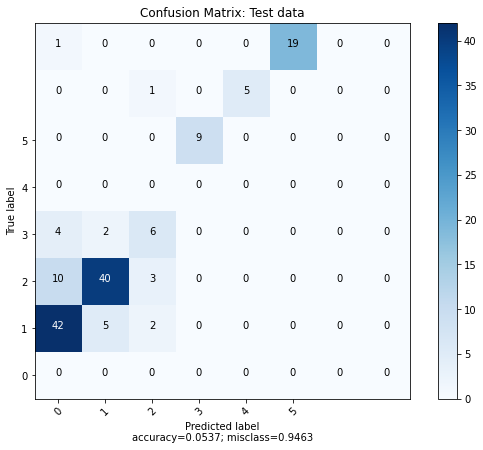

In [12]:
y_pred = model.predict(X)

print(f'Accuracy: {round(sum(y_pred==y)/(len(y)/100),2)}%') # Check accuracy of the decision tree at this level

# Print Confusion matrix
confu = confusion_matrix(df['type'], y_pred)

plot_confusion_matrix(cm           = confu, 
                      normalize    = False,
                      target_names = ['0', '1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")

[(0, 'RI'), (1, 'Na'), (2, 'Mg'), (3, 'Al'), (4, 'Si'), (5, 'K'), (6, 'Ca'), (7, 'Ba'), (8, 'Fe')]


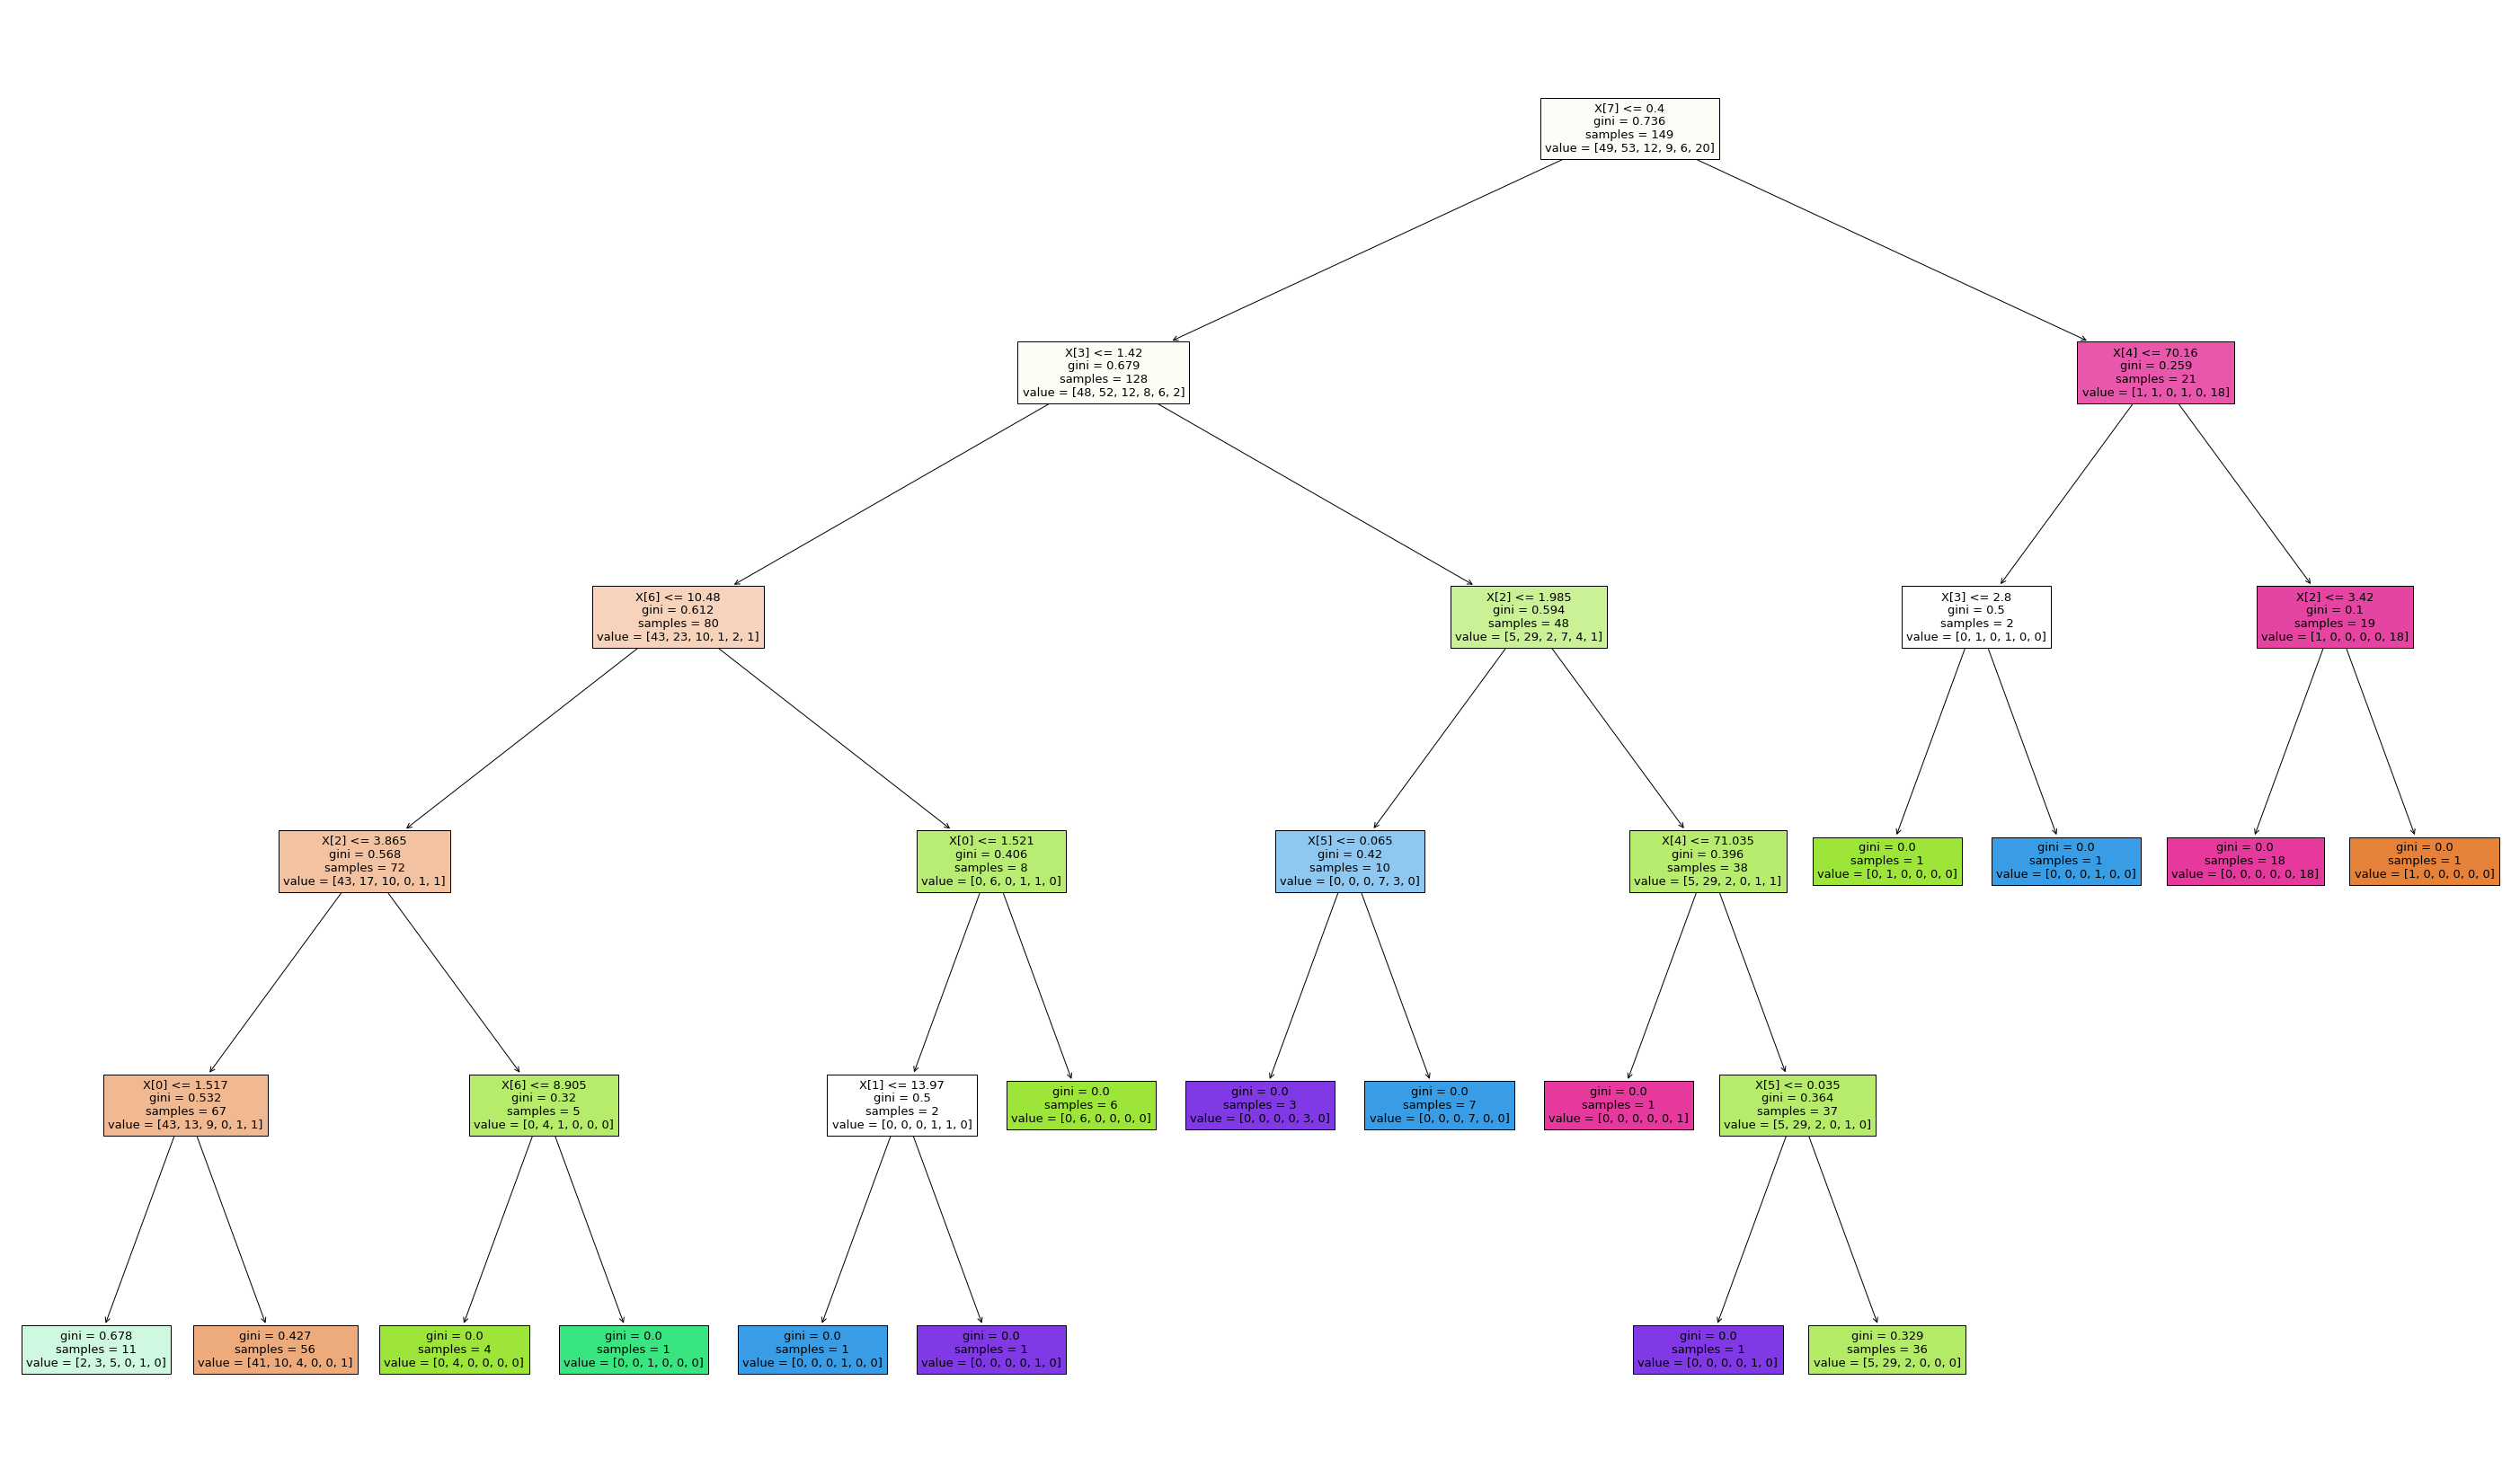

In [13]:
fig = plt.figure(figsize=(50,30))
_ = tree.plot_tree(model, filled=True)
print([(i, attributes[i]) for i in range(len(attributes))]);
#plt.savefig('../Vis/sklearn_tree');

In [14]:
#plt.scatter([i for i in range(149)], df['Ba'], c=y, cmap=col)
#plt.hlines(0.4, 0, 149)
#plt.title('Ba');

## Visualize Splits from the Home-made classifier

128 21
{'best_gini': 0.6050781249999999, 'best_threshold': 1.42, 'best_att': 'Al', 'node_gini': 0.67919921875, 'class_count': array([ 0, 48, 52, 12,  0,  8,  6,  2])}


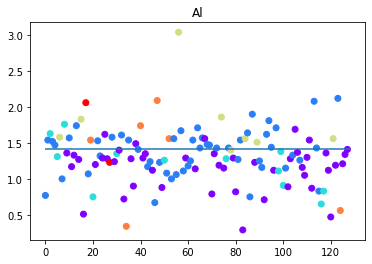

In [15]:
# Visualize one of the second splits
a_df = df[df[leaf['best_att']] <= leaf["best_threshold"]].copy()
b_df = df[df[leaf['best_att']] > leaf["best_threshold"]].copy()
print(a_df.shape[0], b_df.shape[0])

leaf_a  = leaf_hunter(a_df)

print(leaf_a)

plt.scatter([i for i in range(a_df.shape[0])], a_df[leaf_a['best_att']], c=a_df['type'], cmap=col)
plt.hlines(leaf_a["best_threshold"], 0, a_df.shape[0])
plt.title(f'{leaf_a["best_att"]}');
#plt.savefig('../Vis/a_split');

{'best_gini': 0.1378446115288221, 'best_threshold': 70.16, 'best_att': 'Si', 'node_gini': 0.2585034013605442, 'class_count': array([ 0,  1,  1,  0,  0,  1,  0, 18])}


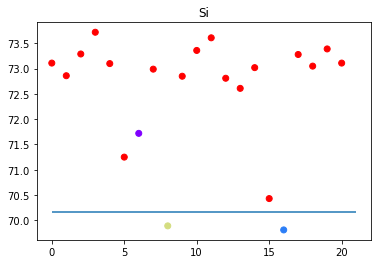

In [16]:
# Visualize the other second split
leaf_b  = leaf_hunter(b_df)

print(leaf_b)

plt.scatter([i for i in range(b_df.shape[0])], b_df[leaf_b['best_att']], c=b_df['type'], cmap=col)
plt.hlines(leaf_b["best_threshold"], 0, b_df.shape[0])
plt.title(f'{leaf_b["best_att"]}');
#plt.savefig('../Vis/b_split');

## Create a tree using the full training set to compare to sklearn's decision tree

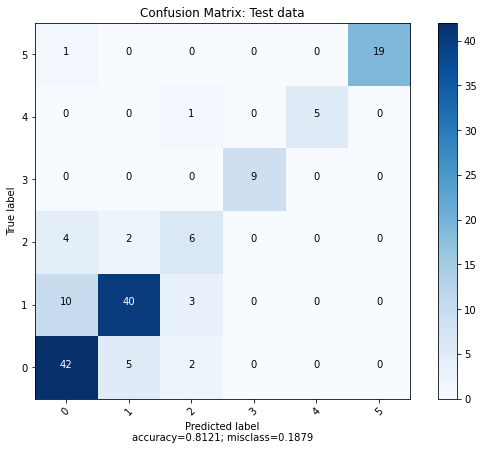

In [17]:
bob = DecisionTree(df)#, tree_text=True, print_nodes=True) # This fits the model to the data equiv to .fit()

bob_pred = bob.predict(X, force_depth= 5)

# Print Confusion matrix
confu = confusion_matrix(df['type'], bob_pred)

plot_confusion_matrix(cm           = confu, 
                      normalize    = False,
                      target_names = ['0', '1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")

The confusion matrix is the same as the reference implementation from sklearn

## Performance metrics from our tree model

In [18]:
recall, precision, f1 = scores(np.array(bob_pred), np.array(df['type']), average = True)

print(f'Recall: {round(recall,3)}\nPrecision: {round(precision,3)}\nF1: {round(f1,3)}')

Recall: 0.816
Precision: 0.848
F1: 0.829


In [19]:
y_pred = bob.predict(X, force_depth=5) #As model 'bob' has been run until all nodes are pure, not capping the depth should give 100% accuracy if the model is correct

print(f'Accuracy: {round(sum(y_pred==y)/(len(y)/100),2)}%') # Check accuracy of the decision tree at this level

Accuracy: 8.05%


The accuracy also matches the reference implementation.

## K-Fold

In [20]:
depths = [3,4,5,6,7,8,9,10] # control depth of tree
mini = df # this was so I could run smaller tests easily ie df[0:10] for speed
score = {}
fold = 1
results = {} # holds the predictions for each fold
splits = 2

kf = KFold(n_splits=splits) # create the size of the splits
F1_list = [] # holds the F1 scores for each fold 
for train, test in kf.split(mini[attributes]):    
    # train a DT for current fold depth
    luci = DecisionTree(pd.DataFrame(mini.iloc[train]), max_depth=max(depths))
    for d in depths:
        c = 0 # controls the count through the results
        pred = luci.predict(pd.DataFrame(mini[attributes].iloc[test]), force_depth=d) #predict for current fold
        results[(fold,d)] = [j for j in zip(train,pred)] #store index and prediction
        f1 = f1_score(np.array(mini['type'].iloc[test]), np.array(pred), average='weighted')
        #print(f"F1: {round(f1, 2)}")
        F1_list.append(f1)

        print(f'Fold: {fold}, Depth: {d}, F1: {f1}')
    fold += 1
    print('------------')
    
    
trials = {}
for i in range(len(depths)*splits):
    if i%len(depths) in trials.keys():
        trials[(i%len(depths))].append(F1_list[i])
    else:
        trials[(i%len(depths))] = [F1_list[i]]
        
for k, v in trials.items():
    score[depths[k]] = round(sum(v)/len(v), 3)
    
score

Fold: 1, Depth: 3, F1: 0.539783251231527
Fold: 1, Depth: 4, F1: 0.539783251231527
Fold: 1, Depth: 5, F1: 0.5174061624649859
Fold: 1, Depth: 6, F1: 0.5712820512820512
Fold: 1, Depth: 7, F1: 0.6021517530088958
Fold: 1, Depth: 8, F1: 0.5814177978883862
Fold: 1, Depth: 9, F1: 0.5814177978883862
Fold: 1, Depth: 10, F1: 0.5814177978883862
------------
Fold: 2, Depth: 3, F1: 0.5377070619006104
Fold: 2, Depth: 4, F1: 0.5204750204750206
Fold: 2, Depth: 5, F1: 0.5181981981981982
Fold: 2, Depth: 6, F1: 0.5314543114543114
Fold: 2, Depth: 7, F1: 0.5535241123476419
Fold: 2, Depth: 8, F1: 0.5563099751335047
Fold: 2, Depth: 9, F1: 0.5563099751335047
Fold: 2, Depth: 10, F1: 0.5563099751335047
------------


{3: 0.539,
 4: 0.53,
 5: 0.518,
 6: 0.551,
 7: 0.578,
 8: 0.569,
 9: 0.569,
 10: 0.569}

Testing depths to choose optimum as a hyperparameter

2 folds: {3: 0.539,
          4: 0.53,
          5: 0.518,
          6: 0.551,
          7: **0.578**,
          8: 0.569,
          9: 0.569,
          10: 0.569}

3 folds: {3: 0.509,
          4: 0.555,
          5: 0.607,
          6: 0.636,
          7: **0.638**,
          8: 0.631,
          9: 0.631,
          10: 0.631}
          
4 folds: {3: 0.54,
          4: 0.54, 
          5: 0.603, 
          6: **0.634**, 
          7: 0.614, 
          8: 0.611, 
          9: 0.627, 
          10: 0.627}
          
5 folds: {3: 0.51,
          4: **0.594**,
          5: 0.584,
          6: 0.574,
          7: 0.569,
          8: 0.577,
          9: 0.572,
          10: 0.574}

### The optimum depth tends to fall in the region [6,7] so choosing the lower value, 6, seems reasonable as it is quicker to process and the difference between 6&7 is generally small.

# PCA

In [21]:
X_std = z_score(X)

pca = PCA(n_components=9)
pca.fit(X_std)

print(pca.explained_variance_ratio_)
pca_exp = pca.explained_variance_ratio_
s = 0
c = 1
for i in pca_exp:
    s += i
    print(f'{c} components explain {round(100*s,2)}% of the data')
    c+=1

[2.82231856e-01 2.30404087e-01 1.64196203e-01 1.17150428e-01
 1.02153806e-01 5.53756625e-02 4.16823996e-02 6.62823259e-03
 1.77325748e-04]
1 components explain 28.22% of the data
2 components explain 51.26% of the data
3 components explain 67.68% of the data
4 components explain 79.4% of the data
5 components explain 89.61% of the data
6 components explain 95.15% of the data
7 components explain 99.32% of the data
8 components explain 99.98% of the data
9 components explain 100.0% of the data


In [22]:
pca = PCA(n_components=7) # 99% of the data is explained this way
pca.fit(X_std)

X_pca = pd.DataFrame(pca.transform(X_std))

In [23]:
df_pca = pd.concat([pd.DataFrame(X_pca),pd.DataFrame(y)], axis=1)

peter = DecisionTree(df_pca)

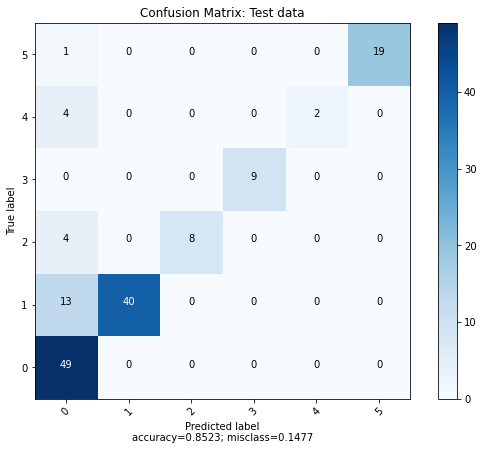

In [24]:
peter_pred = peter.predict(X_pca, force_depth=8)

# Print Confusion matrix
confu = confusion_matrix(y, peter_pred)

plot_confusion_matrix(cm           = confu, 
                      normalize    = False,
                      target_names = ['0', '1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")

So it looks like using PCA first makes the tree grow deeper. Try using k-fold to find best depth again.

In [25]:
splits = 2 # control number of splits
depths = [8,9,10,11,12,] # control depth of tree
mini = df_pca # this was so I could run smaller tests easily ie df[0:10] for speed
score = {}
fold = 1
results = {} # holds the predictions for each fold
attributes = list(df_pca.columns)[:-1]


kf = KFold(n_splits=splits) # create the size of the splits
F1_list = [] # holds the F1 scores for each fold 
for train, test in kf.split(mini[attributes]):    
    # train a DT for current fold depth
    luci = DecisionTree(pd.DataFrame(mini.iloc[train]), max_depth=max(depths))
    for d in depths:
        c = 0 # controls the count through the results
        pred = luci.predict(pd.DataFrame(mini[attributes].iloc[test]), force_depth=d) #predict for current fold
        results[(fold,d)] = [j for j in zip(train,pred)] #store index and prediction
        f1 = f1_score(np.array(mini['type'].iloc[test]), np.array(pred), average='weighted')
        #print(f"F1: {round(f1, 2)}")
        F1_list.append(f1)

        print(f'Fold: {fold}, Depth: {d}, F1: {f1}')
    fold += 1
    print('------------')
    
    
trials = {}
for i in range(len(depths)*splits):
    if i%len(depths) in trials.keys():
        trials[(i%len(depths))].append(F1_list[i])
    else:
        trials[(i%len(depths))] = [F1_list[i]]
        
for k, v in trials.items():
    score[depths[k]] = round(sum(v)/len(v), 3)
    
score

Fold: 1, Depth: 8, F1: 0.49081578266100173
Fold: 1, Depth: 9, F1: 0.4825894228659206
Fold: 1, Depth: 10, F1: 0.4825695611577964
Fold: 1, Depth: 11, F1: 0.48264293520686957
Fold: 1, Depth: 12, F1: 0.48264293520686957
------------
Fold: 2, Depth: 8, F1: 0.5697393822393823
Fold: 2, Depth: 9, F1: 0.5825342687184794
Fold: 2, Depth: 10, F1: 0.5825342687184794
Fold: 2, Depth: 11, F1: 0.5823359843096686
Fold: 2, Depth: 12, F1: 0.5823359843096686
------------


{8: 0.53, 9: 0.533, 10: 0.533, 11: 0.532, 12: 0.532}

2 folds: {8: 0.53, 9: **0.533**, 10: 0.533, 11: 0.532, 12: 0.532}

3 folds: {8: 0.585, 9: 0.574, 10: 0.58, 11: **0.586**, 12: 0.586}

4 folds: {8: 0.555, 9: **0.565**, 10: 0.546, 11: 0.554, 12: 0.548}

5 folds: {8: **0.529**, 9: 0.522, 10: 0.51, 11: 0.527, 12: 0.518}

### This time the optimal depth seems to lie around 9.

# Final Test

In the k-fold tests, the unaltered training set tended to score higher (on F1) scores than the pca-transformed training set, so we will not use the transformed data for our final model. The final cell is left commented out and not run accordingly as this was for the pca version, had we gone with that.

In [26]:
df_test = pd.read_csv(TEST) #test dataframe

attributes = list(df_test.columns)[:-1]

X_test = df_test[attributes].copy() #attributes
y_test = df_test['type'].copy() #true values

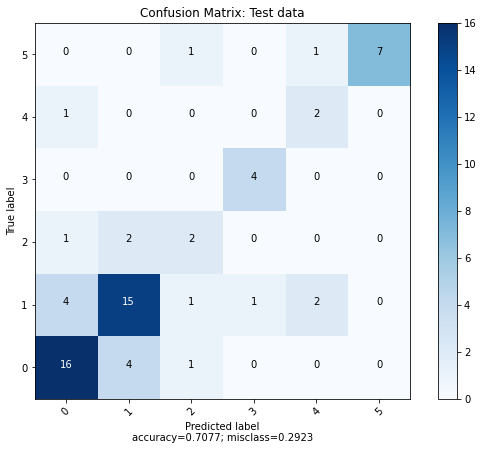

Recall: 0.71
Precision: 0.674
F1: 0.711


In [27]:
'''loads and predicts on the TEST data, 
uncomment this **last** once everything else is in place then don't change anything!'''

final = DecisionTree(df, tree_text=True, max_depth=6) #set depth here

test_pred = final.predict(X_test) 

# Print Confusion matrix
confu = confusion_matrix(y_test, test_pred)

plot_confusion_matrix(cm           = confu, 
                      normalize    = False,
                      target_names = ['0', '1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")

recall, precision, f1 = scores(test_pred, y_test, average = True)
f1 = f1 = f1_score(y_test, test_pred, average='weighted')

print(f'Recall: {round(recall,3)}\nPrecision: {round(precision,3)}\nF1: {round(f1,3)}')

In [28]:
recall, precision, f1 = scores(test_pred, y_test, average = False)
recall = [round(x,3) for x in recall]
precision = [round(x,3) for x in precision]
f1 = [round(x,3) for x in f1]

print(f'Recall per class: {recall}')
print(f'Precision per class: {precision}')
print(f'F1 per class: {f1}')

Recall per class: [0.762, 0.652, 0.4, 1.0, 0.667, 0.778]
Precision per class: [0.727, 0.714, 0.4, 0.8, 0.4, 1.0]
F1 per class: [0.744, 0.682, 0.4, 0.889, 0.5, 0.875]


Interestingly, these scores are higher than we would've predicted based on the k-fold tests. Presumably because there is a larger training set than in any individual k-fold?
As expected, the classes with fewest training examples performed most poorly, namely 2, (vehicle window) & 4 (tableware),although 3 (container) performed well despite fewe cases - maybe this class is more distinctive than the others somehow?

In [29]:
name_dict = {0: 'float_window',
             1: 'non-float_window',
             2: 'vehicle_window',
             3: 'container',
             4: 'Tableware',
             5: 'Headlamp'}

In [30]:
'''For completeness, again, don't uncomment until everything is decided re which cell to use.'''
'''
X_test_std = z_score(X_test)

X_test_pca = pd.DataFrame(pca.transform(X_test_std))

df_test_pca = pd.concat([pd.DataFrame(X_pca),pd.DataFrame(y)], axis=1)

final_pca = DecisionTree(df_pca, max_depth=9) #set depth here

pca_test_pred = final_pca.predict(X_test_pca)

# Print Confusion matrix
confu = confusion_matrix(y_test, pca_test_pred)

plot_confusion_matrix(cm           = confu, 
                      normalize    = False,
                      target_names = ['1', '2', '3', '5', '6', '7'],
                      title        = "Confusion Matrix: Test data")

recall, precision, f1 = scores(pca_test_pred, y_test, average = True)

print(f'Recall: {round(recall,3)}\nPrecision: {round(precision,3)}\nF1: {round(f1,3)}')''';